# Causal Inference in Decision Intelligence – Part 20: Simulation and Scenario Modeling

Link to the article:  [Simulation and Scenario Modeling](https://www.linkedin.com/pulse/causal-inference-decision-intelligence-part-20-eugene-zinoviev-4cdbc)

## Import libraries

In [ ]:
# Check if dowhy is installed, and install it if not
try:
    import dowhy
except ImportError:
    import subprocess
    import sys
    print("Installing dowhy...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "dowhy"])
    import dowhy

In [1]:
from collections import OrderedDict

import numpy as np
import pandas as pd
import networkx as nx

import dowhy.gcm as gcm
from dowhy.utils import plot

from dowhy import CausalModel

from scipy import linalg 
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

pd.options.display.float_format='{:,.2f}'.format

## Create the true Directed Acyclic Graph (DAG)

In [45]:
# Create the true DAG
G = nx.DiGraph([('Macro', 'Sales'), ('Macro', 'Price'), ('Macro', 'Marketing'), 
                ('Income', 'Sales'), ('Price', 'Sales'), ('Marketing', 'Visits'), 
                ('Visits', 'Sales'), ('Sales', 'Revenue'), ('Price', 'Revenue'),
                ('Sales', 'Sales_costs'), ('Marketing', 'Profit'), 
                ('Sales_costs', 'Profit'), ('Revenue', 'Profit')])

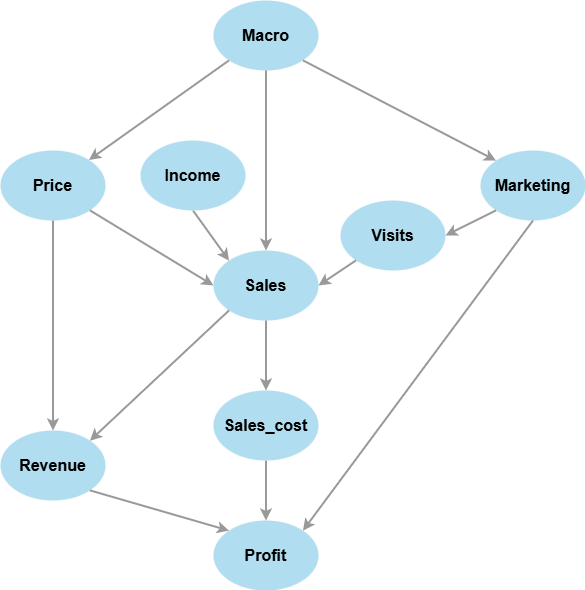

## Generate the data

In [2]:

np.random.seed(3)

# Generate customers' Ids 
Id = pd.Series(range(1,1001))

# Generate Income variable 
#Income = np.random.choice(["Low", "Medium", "High"], size=1000, p=[0.5, 0.35, 0.15])
Income = np.random.choice([1, 2, 3], size=1000, p=[0.5, 0.35, 0.15])


data = pd.DataFrame({"Id": Id, "Income": Income})

# Generate dates 
Year = pd.Series(range(2020,2024))

# Create the product of Ids and Years
year = pd.DataFrame({'Year': Year})
data = year.merge(data, how='cross')

# Generate Macro variable 
data["Macro"] = np.where(((data.Year==2022) | (data.Year==2020)), 1, 0)

# Create Price variable 
data['Price'] = 10 + 2 * data.Macro + np.random.normal(loc=0, scale=0.5, size=4000) 

# Create other variables 
data['Marketing'] = 80 - 10 * data.Macro + np.random.normal(loc=2, scale=1, size=4000) 
data['Visits'] = 0.1 * data.Marketing + np.random.normal(loc=0, scale=0.5, size=4000) 

data['Sales'] = 80 + 28 * data.Macro + 14 * data.Income - 7 * data.Price + 4 * data.Visits + np.random.normal(loc=0, scale=5, size=4000)


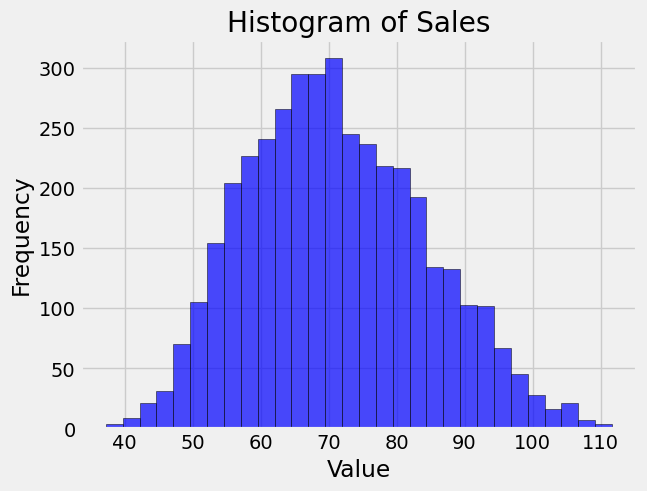

In [47]:
data['Sales'].plot.hist(bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Sales')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show();

In [3]:
# Add Costs, Revenue and Profit variables
np.random.seed(3)

data['Sales_costs'] = 2 * data['Sales']
data['Revenue'] = data['Price'] * data['Sales']
data['Profit'] = data['Revenue'] - data['Sales_costs'] - data['Marketing']
data

,Year,Id,Income,Macro,Price,Marketing,Visits,Sales,Sales_costs,Revenue,Profit
0,2020,1,2,1,11.53,72.09,7.08,76.55,153.11,882.95,657.74
1,2020,2,2,1,11.38,72.77,7.55,81.91,163.81,932.09,695.51
2,2020,3,1,1,12.33,71.59,7.17,63.22,126.45,779.49,581.45
3,2020,4,2,1,11.08,70.46,7.73,88.22,176.44,977.82,730.91
4,2020,5,3,1,12.48,72.89,7.63,95.30,190.61,"1,189.56",926.06
...,...,...,...,...,...,...,...,...,...,...,...
3995,2023,996,1,0,9.26,83.33,7.72,65.57,131.14,607.23,392.76
3996,2023,997,2,0,9.67,80.50,7.40,75.23,150.45,727.54,496.59
3997,2023,998,1,0,10.25,84.99,8.96,54.03,108.05,553.97,360.93
3998,2023,999,1,0,10.01,80.67,8.30,55.54,111.08,555.99,364.25


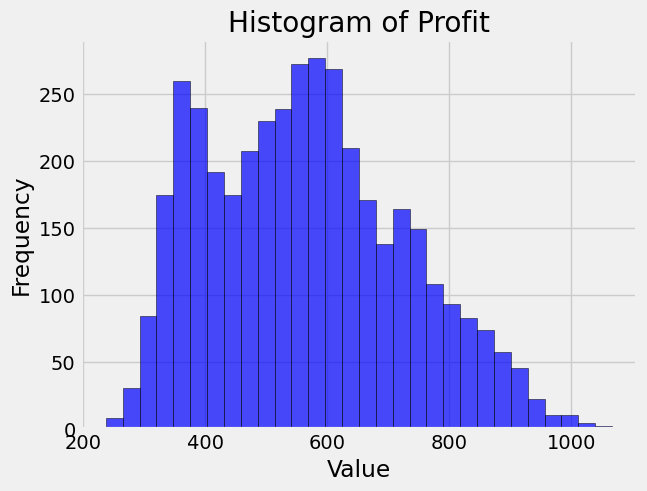

In [49]:
data['Profit'].plot.hist(bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Profit')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show();

## Use Linear Regression for simulation

### Model Sales

In [15]:
# Estimate the causal effect of the variables on Sales
model_p = smf.ols('Sales ~ Marketing+Macro', data).fit()

model_p.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,15.2837,15.650,0.977,0.329,-15.398,45.966
Marketing,0.6207,0.191,3.253,0.001,0.247,0.995
Macro,16.0966,1.947,8.266,0.000,12.279,19.914


In [50]:
# Estimate the causal effect of the variables on Sales
model_p = smf.ols('Sales ~ Marketing + Macro + Price + C(Income)', data).fit()

model_p.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,97.0103,7.235,13.408,0.000,82.825,111.195
C(Income)[T.2],14.5756,0.188,77.655,0.000,14.208,14.944
C(Income)[T.3],28.3936,0.256,110.936,0.000,27.892,28.895
Marketing,0.3659,0.086,4.277,0.000,0.198,0.534
Macro,27.6649,0.937,29.535,0.000,25.828,29.501
Price,-7.0492,0.173,-40.780,0.000,-7.388,-6.710


In [51]:
# Predict Sales
data_p = data[['Year', 'Id', 'Marketing', 'Price', 'Macro', 'Income']]
data_p["Sales_predicted"] = model_p.predict(data_p)

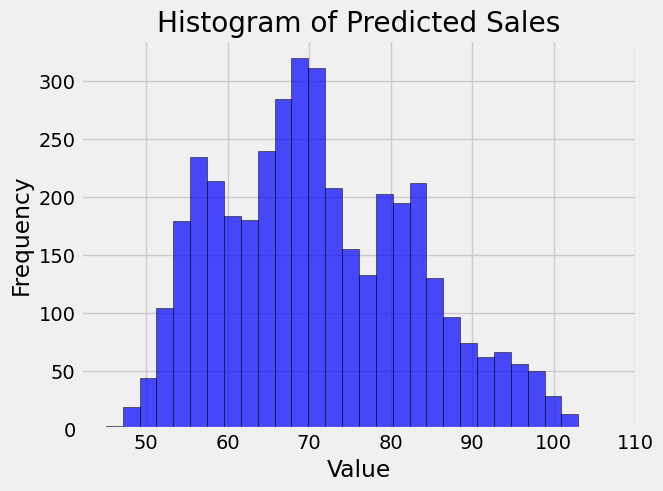

In [53]:
# Draw the histogram of predicted sales
data_p['Sales_predicted'].plot.hist(bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Predicted Sales')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show();

### Calculate Profit

In [54]:
# Calculate the costs and profit
np.random.seed(3)
data_p['Sales_ costs'] = 2 *data_p["Sales_predicted"]

#data_p['Revenue'] = data_p['Price'] * data_p['Sales']
data_p['Profit'] = data_p['Sales_predicted'] * data_p['Price'] - data_p['Sales_ costs'] - data_p['Marketing']
data_p.head()

,Year,Id,Marketing,Price,Macro,Income,Sales_predicted,Sales_ costs,Profit
0,2020,1,72.09,11.53,1,2,84.33,168.65,731.82
1,2020,2,72.77,11.38,1,2,85.66,171.31,730.67
2,2020,3,71.59,12.33,1,1,63.96,127.92,589.03
3,2020,4,70.46,11.08,1,2,86.90,173.80,718.90
4,2020,5,72.89,12.48,1,3,91.75,183.50,888.82


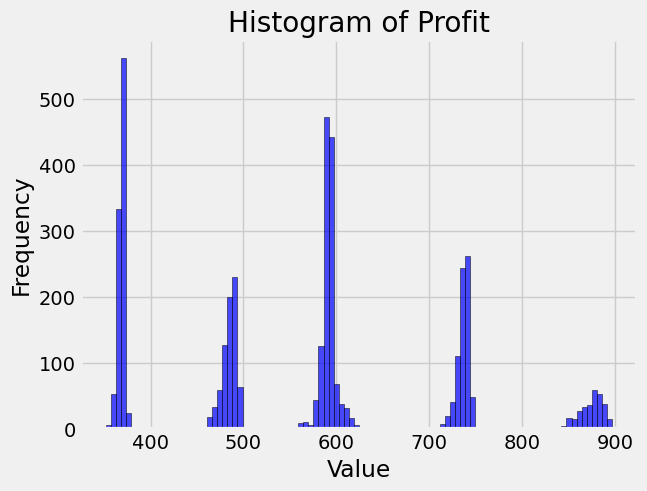

In [55]:
# Draw a histogram of profit
data_p['Profit'].plot.hist(bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Profit')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show();

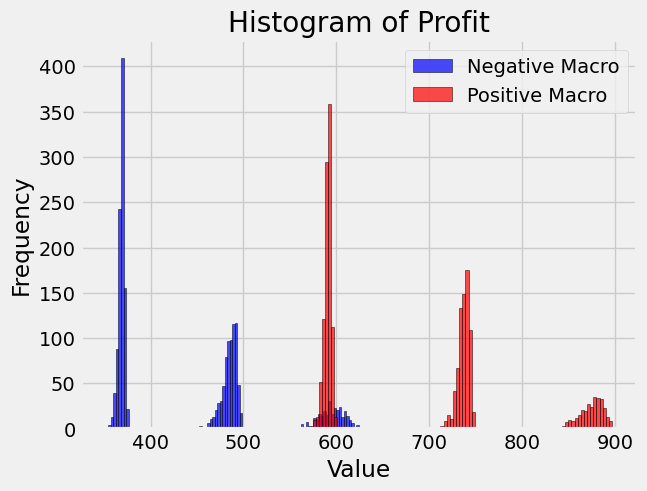

In [56]:
# Draw a histograms of profit for Macro=0 and Macro=1
data_p[data_p.Macro==0]['Profit'].plot.hist(bins=100, alpha=0.7, color='blue', edgecolor='black', label='Negative Macro')
data_p[data_p.Macro==1]['Profit'].plot.hist(bins=100, alpha=0.7, color='red', edgecolor='black', label='Positive Macro')
plt.title('Histogram of Profit')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show();

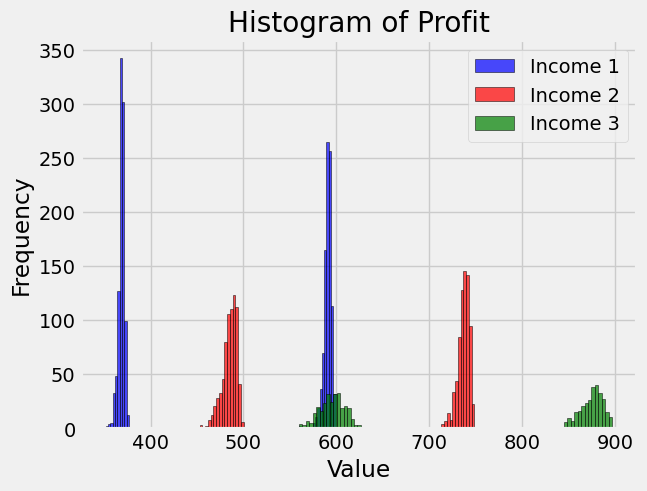

In [57]:
# Draw a histogram of profit
data_p[data_p.Income==1]['Profit'].plot.hist(bins=100, alpha=0.7, color='blue', edgecolor='black', label='Income 1')
data_p[data_p.Income==2]['Profit'].plot.hist(bins=100, alpha=0.7, color='red', edgecolor='black', label='Income 2')
data_p[data_p.Income==3]['Profit'].plot.hist(bins=100, alpha=0.7, color='green', edgecolor='black', label='Income 3')
plt.title('Histogram of Profit')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show();

### Simulate Profit

In [84]:
# Include data generation, prediction of sales, and calculation of profit in function "profit"
def profit(df):
    """
    The function calculates total profit
    Inputs:
        df: Pandas dataframe with "macro", "price" and "market" columns
    Output:
        Total profit value
    """
    np.random.seed(4)

    df["Sales_predicted"] = model_p.predict(df)

    df['Sales_ costs'] = 2 * df["Sales_predicted"]

    df['Profit'] = df['Sales_predicted'] * df['Price'] - df['Sales_ costs'] - df['Marketing']
     
    return df['Profit'].mean()



In [86]:
# Scenario 1
# Simulate "profit" with stochastic values of Macro and Price and fixed marketing budget

np.random.seed(4)
# Set the number of simulations
n_sim = 10000

# Generate Macro state with some probabilities
macro_state = [0, 1]
prob = [0.3, 0.7]
macro = np.random.choice(macro_state, size=n_sim, p=prob)

# Generate Income variable 
income = np.random.choice([1, 2, 3], size=n_sim, p=[0.5, 0.35, 0.15])

# Generate prices with some probabilities
price_state = [8, 10, 12, 14]
prob_p = [0.25, 0.25, 0.25, 0.25]
price = np.random.choice(price_state, size=n_sim, p=prob_p)

# Generate marketing budget with some probabilities
marketing = 80

# Create a dataframe
df = pd.DataFrame({'Income': income, 'Macro': macro, 'Price': price, 'Marketing': marketing})
df['Profit'] = df.apply(profit, axis=1)
df

,Income,Macro,Price,Marketing,Profit
0,2,1,8,80,592.76
1,3,1,14,80,923.78
2,2,1,8,80,592.76
3,2,1,8,80,592.76
4,1,1,10,80,587.62
...,...,...,...,...,...
9995,2,1,14,80,757.97
9996,1,0,10,80,366.30
9997,1,1,10,80,587.62
9998,1,1,10,80,587.62


In [89]:
# Finding the optimal prices for different macro environments and income levels/
avg_profit = df.groupby(['Macro', 'Income', 'Price']).Profit.mean().reset_index()
max_profit_price = avg_profit.loc[avg_profit.groupby(['Macro', 'Income'])['Profit'].idxmax()]
max_profit_price = max_profit_price.sort_values(by=['Macro', 'Income']).reset_index(drop=True)

pd.DataFrame(max_profit_price)

,Macro,Income,Price,Profit
0,0,1,10,366.30
1,0,2,10,482.90
2,0,3,12,620.82
3,1,1,12,613.53
4,1,2,12,759.29
5,1,3,14,923.78


In [90]:
# Simulate "profit" with stochastic marketing budget, Macro=0, and Price=10

# Set the number of simulations
n_sim = 10000

# Generate Macro state with some probabilities
macro_state = [0, 1]
prob = [0.3, 0.7]
macro = np.random.choice(macro_state, size=n_sim, p=prob)

# Generate Income variable 
income = np.random.choice([1, 2, 3], size=n_sim, p=[0.5, 0.35, 0.15])

# Set prices at 10
price = 10

# Generate marketing budget with some probabilities
market_state = [50, 60, 70, 80, 100]
prob_m = [0.2, 0.2, 0.2, 0.2, 0.2]
marketing = np.random.choice(market_state, size=n_sim, p=prob_m)

# Create a dataframe
dfp = pd.DataFrame({'Income': income, 'Macro': macro, 'Price': price, 'Marketing': marketing})
dfp['Profit'] = dfp.apply(profit, axis=1)
dfp

,Income,Macro,Price,Marketing,Profit
0,2,1,10,60,665.68
1,3,1,10,100,853.30
2,2,1,10,50,646.41
3,2,1,10,60,665.68
4,1,1,10,70,568.35
...,...,...,...,...,...
9995,2,1,10,100,742.76
9996,1,0,10,70,347.03
9997,1,1,10,60,549.08
9998,1,1,10,60,549.08


In [91]:
# Finding the optimal prices for different macro environments and income levels/
avg_profit_p = dfp.groupby(['Macro', 'Income', 'Marketing']).Profit.mean().reset_index()
max_profit_price_p = avg_profit_p.loc[avg_profit_p.groupby(['Macro', 'Income'])['Profit'].idxmax()]
max_profit_price_p = max_profit_price_p.sort_values(by=['Macro', 'Income']).reset_index(drop=True)

pd.DataFrame(max_profit_price_p)

,Macro,Income,Marketing,Profit
0,0,1,100,404.83
1,0,2,100,521.44
2,0,3,100,631.98
3,1,1,100,626.15
4,1,2,100,742.76
5,1,3,100,853.30


## Use Graphical Causal Model (GCM) for simulation

### Model Profit

In [92]:
# Build Structural causal model on top of the causal graph
np.random.seed(3)
causal_model = gcm.StructuralCausalModel(G)

# Assign causal mechanisms to each node
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data)

# Fit the graphical causal model
gcm.fit(causal_model, data)

Fitting causal mechanism of node Profit: 100%|███████████████████████████████████████████| 9/9 [00:01<00:00,  8.77it/s]


In [93]:
# Draw 10,000 samples from Graphical Causal Model 
np.random.seed(3)
generated_data = gcm.draw_samples(causal_model, num_samples=10000)
generated_data.head()

,Macro,Income,Price,Marketing,Visits,Sales,Revenue,Sales_costs,Profit
0,0,2,9.36,81.82,7.96,67.06,627.49,134.11,411.56
1,0,1,10.50,82.77,9.02,53.64,563.23,107.29,373.17
2,0,2,9.65,81.25,8.58,81.90,790.20,163.81,545.14
3,0,2,10.01,82.71,8.33,65.24,653.32,130.47,440.14
4,0,1,10.60,79.68,7.85,45.27,479.79,90.54,309.56


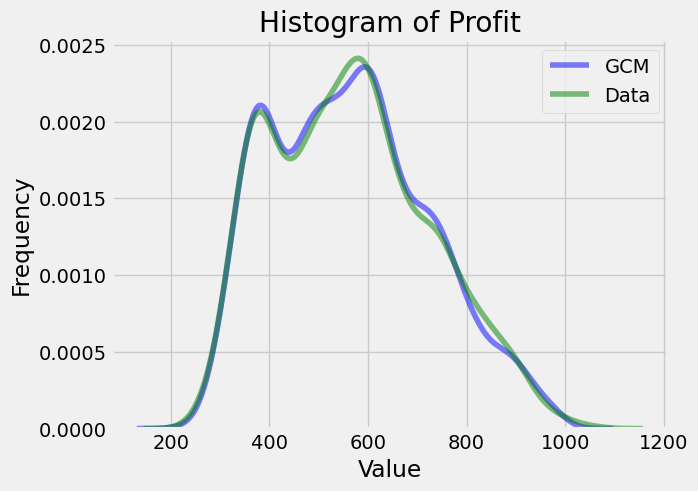

In [94]:
# Compare data sampled from GCM to the real data
sns.kdeplot(generated_data.Profit, fill=False, color='blue', alpha=0.5, label='GCM')
sns.kdeplot(data.Profit, fill=False, color='green', alpha=0.5, label='Data')
plt.title('Histogram of Profit')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.show();

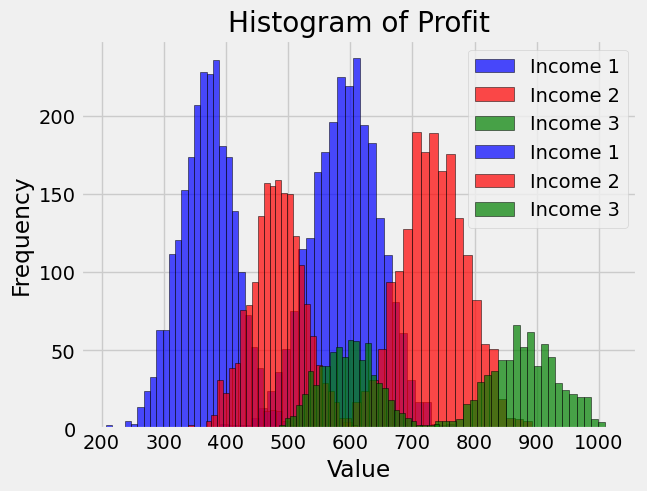

In [95]:
# Draw a histogram of profit
generated_data[(generated_data.Income==1) & (generated_data.Macro==1)]['Profit'].plot.hist(bins=30, alpha=0.7, color='blue', edgecolor='black', label='Income 1')
generated_data[(generated_data.Income==2) & (generated_data.Macro==1)]['Profit'].plot.hist(bins=30, alpha=0.7, color='red', edgecolor='black', label='Income 2')
generated_data[(generated_data.Income==3) & (generated_data.Macro==1)]['Profit'].plot.hist(bins=30, alpha=0.7, color='green', edgecolor='black', label='Income 3')
generated_data[(generated_data.Income==1) & (generated_data.Macro==0)]['Profit'].plot.hist(bins=30, alpha=0.7, color='blue', edgecolor='black', label='Income 1')
generated_data[(generated_data.Income==2) & (generated_data.Macro==0)]['Profit'].plot.hist(bins=30, alpha=0.7, color='red', edgecolor='black', label='Income 2')
generated_data[(generated_data.Income==3) & (generated_data.Macro==0)]['Profit'].plot.hist(bins=30, alpha=0.7, color='green', edgecolor='black', label='Income 3')
plt.title('Histogram of Profit')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show();

### Simulate Profit

In [96]:
# Compare two scenarios (favorable and unfavorable macro environments)
np.random.seed(3)
samples1 = gcm.interventional_samples(causal_model,
                                     {'Macro': lambda x: 1},
                                     num_samples_to_draw=4000)

samples0 = gcm.interventional_samples(causal_model,
                                     {'Macro': lambda x: 0},
                                     num_samples_to_draw=4000)

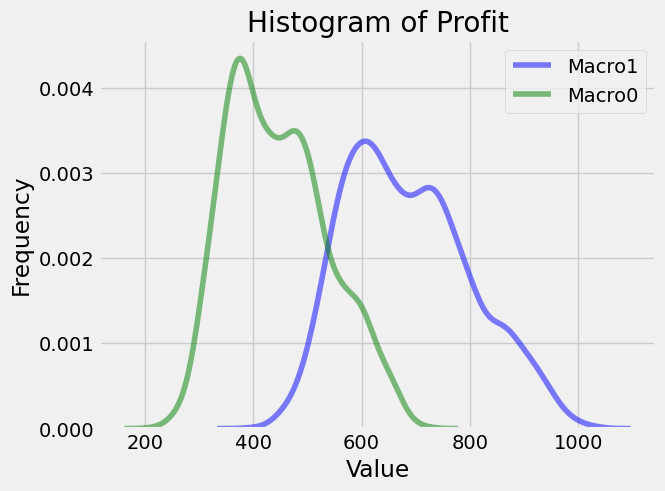

In [97]:
sns.kdeplot(samples1.Profit, fill=False, color='blue', alpha=0.5, label='Macro1')
sns.kdeplot(samples0.Profit, fill=False, color='green', alpha=0.5, label='Macro0')
plt.title('Histogram of Profit')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.show();

In [98]:
# Draw interventional samples with prices increased by 2
np.random.seed(3)
samples_n = gcm.interventional_samples(causal_model,
                                     {'Price': lambda x: x+2},
                                     num_samples_to_draw=4000)
samples_n.head()

,Macro,Income,Price,Marketing,Visits,Sales,Revenue,Sales_costs,Profit
0,0,1,12.21,81.43,8.25,38.00,463.97,76.01,306.54
1,0,2,11.91,82.85,7.85,54.28,646.34,108.57,454.92
2,0,2,12.59,82.54,7.53,49.41,622.20,98.82,440.84
3,0,3,11.66,81.13,7.78,66.85,779.75,133.70,564.92
4,0,2,12.33,82.41,7.22,43.47,535.96,86.94,366.61


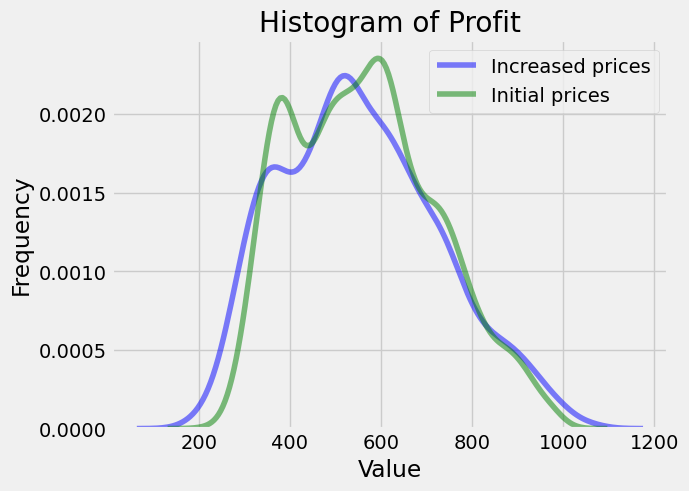

In [99]:
# Show the result of the prices increase
sns.kdeplot(samples_n.Profit, fill=False, color='blue', alpha=0.5, label='Increased prices')
sns.kdeplot(generated_data.Profit, fill=False, color='green', alpha=0.5, label='Initial prices')
plt.title('Histogram of Profit')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.show();

In [100]:
# Find the optimal prices 
np.random.seed(3)
print(f'Optimal price maximizing the profit:')
for macro in [0,1]: 
    dict={}
    for income in [1, 2, 3]:
        for price in [8, 9, 10, 11, 12, 13, 14, 15]:
            profit = gcm.interventional_samples(causal_model, {'Macro': lambda x: macro, 'Income': lambda x: income, 
                                                               'Price': lambda x: price}, num_samples_to_draw=4000).Profit.mean()
            dict[price] = round(profit, 1)
        print(f'Macro={macro}, Income={income}: ${max(dict, key=dict.get)}')

Optimal price maximizing the profit:
Macro=0, Income=1: $10
Macro=0, Income=2: $11
Macro=0, Income=3: $12
Macro=1, Income=1: $12
Macro=1, Income=2: $13
Macro=1, Income=3: $14


In [101]:
# Calculate the total annual profit for optimized prices
Total_profit_growth_macro0 = 500 * 375.2 + 350 * 485.4 + 150 * 606.3
Total_profit_growth_macro1 = 500 * 600.3 + 350 * 736.5 + 150 * 881.6
print(f'Total annual profit for a bad year (Macro=0): ${round(Total_profit_growth_macro0, 2)}')
print(f'Total annual profit for a good year (Macro=1): ${round(Total_profit_growth_macro1, 2)}')

Total annual profit for a bad year (Macro=0): $448435.0
Total annual profit for a good year (Macro=1): $690165.0


In [102]:
# Calculate the total annual profit for old prices
generated_data.groupby('Macro').Profit.mean() * 1000

Macro
0   442,733.35
1   683,186.38
Name: Profit, dtype: float64